In [ ]:
# Importing libaries 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

# scaling and train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#statistical Tools
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc



 

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Data Science/ML_Artivatic_dataset/ML_Artivatic_dataset/train_indessa.csv')
test=pd.read_csv('/content/drive/MyDrive/Data Science/ML_Artivatic_dataset/ML_Artivatic_dataset/test_indessa.csv')
train1=train.copy()

In [ ]:
train1.shape

(532428, 45)

Response Variable: going to predict the loan_status variable, what are the value counts for this variable?



In [ ]:
train['loan_status'].value_counts(normalize=True, dropna=False)

0    0.763673
1    0.236327
Name: loan_status, dtype: float64

About 76% of the remaining loans have been Non-Defaulters nad 23% have Defaulters,So have a somewhat unbalanced classification problem.

In [ ]:
# combining the train and test dataset for EDA
loan_status=train.loan_status
train.drop('loan_status',axis=1,inplace=True)
member_id=test.member_id
data=train.append(test)
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0


In [ ]:
# data.describe()
 

Limit the Featue Space

1.   Drop features with more than 30% of their data missing.
2.   Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.



In [ ]:
# Drop features missing more than 30% data
# calculating the % of missing data for each features

missing_features=data.isnull().mean().sort_values(ascending=False)

In [ ]:
missing_features.head(10)

verification_status_joint      0.999424
desc                           0.858257
mths_since_last_record         0.845553
mths_since_last_major_derog    0.750160
mths_since_last_delinq         0.511971
batch_enrolled                 0.147342
total_rev_hi_lim               0.079195
tot_coll_amt                   0.079195
tot_cur_bal                    0.079195
emp_title                      0.057993
dtype: float64

Text(0, 0.5, 'feature count')

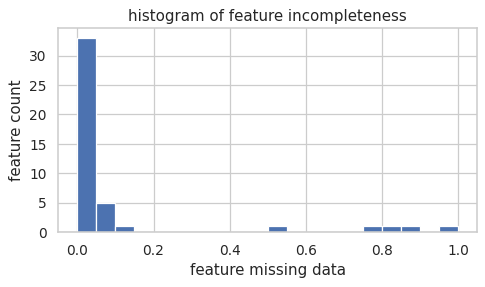

In [ ]:
#let's visualize the distribution of missing data %

plt.figure(figsize=(6,3),dpi=90)
missing_features.plot.hist(bins=20)
plt.title('histogram of feature incompleteness')
plt.xlabel('feature missing data')
plt.ylabel('feature count')

From the above histogram,few geatures have more than 30% of missing data, Because it's generally very difficult to accurately impute data with more than 30% missing values,drop such columns

In [ ]:
drop_list=sorted(list(missing_features[missing_features > 0.3].index))
print(drop_list)

['desc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'verification_status_joint']


In [ ]:
data.drop(labels=drop_list, axis=1, inplace=True)
data.shape

(887379, 39)

In [ ]:
keep_list = ['member_id','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [ ]:
# list of features to drop is any features n keep_list ;
drop_list=[col for col in data.columns if col not in keep_list]
print(drop_list)

['funded_amnt', 'funded_amnt_inv', 'batch_enrolled', 'pymnt_plan', 'delinq_2yrs', 'inq_last_6mths', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'last_week_pay', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']


In [ ]:
len(drop_list)

16

In [ ]:
#drop these features    
data.drop(labels=drop_list,axis=1,inplace=True)

# Pre-processing and Exploratory Analysis


1.   Drop the feature if it is not useful for predicting the loan status.
2.  View summary statistics and visualize the data, plotting against the loan status.
3.   Modify the feature to make it useful for modeling, if necessary.





In [ ]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(train1.loc[train1[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(train1[col_name], order=sorted(train1[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=train1, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = train1.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

In [ ]:
print(list(data.columns))

['member_id', 'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type']


In [ ]:
# member_id
data['member_id'].sample(5)

347122     1040804
215484    21309918
92989     55386666
22284     27108622
248050    16190066
Name: member_id, dtype: int64

In [ ]:
data['member_id'].describe()

count    8.873790e+05
mean     3.500182e+07
std      2.411335e+07
min      7.047300e+04
25%      1.087713e+07
50%      3.709528e+07
75%      5.847135e+07
max      7.354484e+07
Name: member_id, dtype: float64

they are all unique. The memeber_id is not useful for modeling, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance),droping this variable.

In [ ]:
data.drop('member_id', axis=1, inplace=True)

In [ ]:
#loan_amnt
data['loan_amnt'].describe()

count    887379.000000
mean      14755.264605
std        8435.455601
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$35,000, with a median of \$13,000.

In [120]:
# plot_var('loan_amnt', 'Loan Amount', continuous=True)

In [ ]:
train1.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,406601.0,15206.679337,8499.937514,500.0,8700.0,14000.0,20000.0,35000.0
1,125827.0,13306.413965,8049.663290,500.0,7125.0,12000.0,18000.0,35000.0


In [ ]:
# term
data['term'].value_counts(dropna=False)

36 months    621125
60 months    266254
Name: term, dtype: int64

In [ ]:
#Convert term to integers. 
data['term'] = data['term'].apply(lambda s: np.int8(s.split()[0]))

In [ ]:
data['term'].value_counts(normalize=True)

36    0.699955
60    0.300045
Name: term, dtype: float64

About 70% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

In [ ]:
train1.groupby('term')['loan_status'].value_counts(normalize=True)

term       loan_status
36 months  0              0.727267
           1              0.272733
60 months  0              0.848692
           1              0.151308
Name: loan_status, dtype: float64

In [ ]:
# data.groupby('term')['loan_status'].value_counts(normalize=True)

In [ ]:
# int_rate
data['int_rate'].describe()

count    887379.000000
mean         13.246740
std           4.381867
min           5.320000
25%           9.990000
50%          12.990000
75%          16.200000
max          28.990000
Name: int_rate, dtype: float64

In [121]:
# plot_var('int_rate', 'Interest Rate', continuous=True)

In [ ]:
train1.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,406601.0,13.236660,4.418598,5.32,9.99,12.99,16.29,28.99
1,125827.0,13.263356,4.251138,5.32,10.16,13.11,15.80,28.99


In [ ]:
# grade,sub_grade
print(sorted(data['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [ ]:
print(sorted(data['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade,droping the grade column.

In [ ]:
data.drop('grade', axis=1, inplace=True)

In [ ]:
# emp_title
data['emp_title'].describe()

count      835917
unique     289206
top       Teacher
freq        13807
Name: emp_title, dtype: object

too many different job titles for this feature to be useful, so droping it.

In [ ]:
data.drop(labels='emp_title', axis=1, inplace=True)

In [ ]:
# emp_length
data['emp_length'].value_counts(dropna=False).sort_index()


1 year        57095
10+ years    291569
2 years       78870
3 years       70026
4 years       52529
5 years       55704
6 years       42950
7 years       44594
8 years       43955
9 years       34657
< 1 year      70605
NaN           44825
Name: emp_length, dtype: int64

Note there are 44825 loans without data on the length of employment.



In [ ]:
# Convert emp_length to integers:
data['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)


In [ ]:
data['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [ ]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [ ]:
data['emp_length'] = data['emp_length'].apply(emp_length_to_int)

In [ ]:
data['emp_length'].value_counts(dropna=False).sort_index()

0.0      70605
1.0      57095
2.0      78870
3.0      70026
4.0      52529
5.0      55704
6.0      42950
7.0      44594
8.0      43955
9.0      34657
10.0    291569
NaN      44825
Name: emp_length, dtype: int64

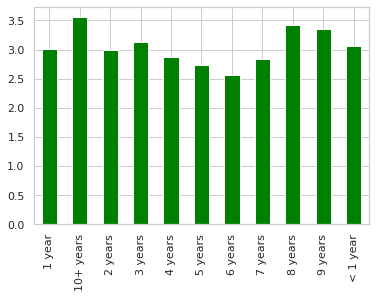

In [ ]:
per_charge_off = train1[train1['loan_status'] == 0]['emp_length'].value_counts() / train1[train1['loan_status'] == 1]['emp_length'].value_counts()
per_charge_off.plot.bar(color='green')

In [ ]:
data.drop(labels='emp_length', axis=1, inplace=True)

In [ ]:
# home_owernship
data['home_ownership'].value_counts(dropna=False)

MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64

In [ ]:
# Replace the values ANY and NONE with OTHER:
data['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [ ]:
data['home_ownership'].value_counts(dropna=False)

MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          235
Name: home_ownership, dtype: int64

In [ ]:
# annual_inc
data['annual_inc'].describe()

count    8.873750e+05
mean     7.502759e+04
std      6.469830e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64

In [ ]:
data['log_annual_inc'] = data['annual_inc'].apply(lambda x: np.log10(x+1))

In [ ]:
data.drop('annual_inc', axis=1, inplace=True)

In [ ]:
data['log_annual_inc'].describe()

count    887375.000000
mean          4.809830
std           0.229551
min           0.000000
25%           4.653222
50%           4.812920
75%           4.954247
max           6.977724
Name: log_annual_inc, dtype: float64

In [ ]:
# train1.groupby('loan_status')['log_annual_inc'].describe()

In [ ]:
# purpose 
data['purpose'].value_counts()

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

In [ ]:
train1.groupby('purpose')['loan_status'].value_counts(normalize=True).sort_values()

purpose             loan_status
credit_card         1              0.206162
educational         0              0.207692
debt_consolidation  1              0.231840
home_improvement    1              0.248625
wedding             0              0.256959
medical             1              0.271839
other               1              0.272220
vacation            1              0.273826
moving              1              0.300956
major_purchase      1              0.318456
small_business      1              0.332574
car                 1              0.367262
renewable_energy    1              0.371601
house               1              0.383410
                    0              0.616590
renewable_energy    0              0.628399
car                 0              0.632738
small_business      0              0.667426
major_purchase      0              0.681544
moving              0              0.699044
vacation            0              0.726174
other               0              0.727780


Notice that only 74% of completed loans for weddings & education have Defaulter,

In [ ]:
# Title 
data['title'].describe()

count                 887227
unique                 61451
top       Debt consolidation
freq                  414352
Name: title, dtype: object

In [ ]:
data['title'].value_counts().head(10)

Debt consolidation         414352
Credit card refinancing    164341
Home improvement            40170
Other                       31892
Debt Consolidation          16414
Major purchase              12051
Business                     6746
Medical expenses             6675
Consolidation                5675
Car financing                5565
Name: title, dtype: int64

There are different titles in the dataset, and based on the top 10 titles, the purpose variable appears to already contain this information. droping the title variable.

In [ ]:
data.drop('title', axis=1, inplace=True)

In [ ]:
#zip_code,addr_state
data['zip_code'].sample(5)

228899    334xx
144650    751xx
381034    035xx
202609    672xx
186431    894xx
Name: zip_code, dtype: object

In [ ]:
data['zip_code'].nunique()

935

In [ ]:
data['addr_state'].sample(5)

250813    AZ
102411    CA
437443    LA
408930    OR
11151     LA
Name: addr_state, dtype: object

In [ ]:
data['addr_state'].nunique()

51

lot of different zip codes,just keeping the state column.

In [ ]:
data.drop(labels='zip_code', axis=1, inplace=True)

In [ ]:
train1.groupby('addr_state')['loan_status'].value_counts(normalize=True).sort_values()

addr_state  loan_status
ND          1              0.017606
ME          1              0.024691
NE          1              0.026798
MS          1              0.089286
TN          1              0.149162
                             ...   
            0              0.850838
MS          0              0.910714
NE          0              0.973202
ME          0              0.975309
ND          0              0.982394
Name: loan_status, Length: 102, dtype: float64

In [ ]:
# dti
data['dti'].describe()

count    887379.000000
mean         18.157039
std          17.190626
min           0.000000
25%          11.910000
50%          17.650000
75%          23.950000
max        9999.000000
Name: dti, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Debt-to-income Ratio')

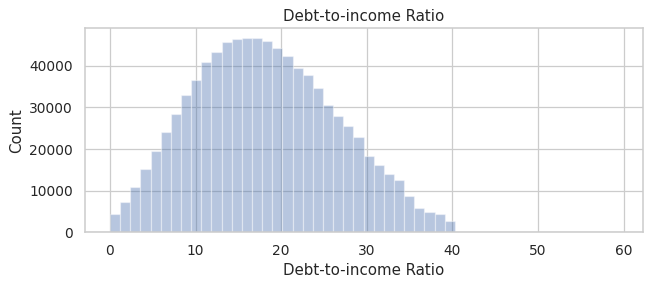

In [ ]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(data.loc[data['dti'].notnull() & (data['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

In [ ]:
# How many of the dti values are "outliers" (above 60)?
(data['dti']>=60).sum()


29

In [ ]:
train1.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,406601.0,18.762716,8.469814,0.0,12.46,18.29,24.73,672.52
1,125827.0,16.122518,7.696557,0.0,10.40,15.74,21.46,57.14


In [ ]:
# # open_acc
# plt.figure(figsize=(10,3), dpi=90)
# sns.countplot(train1=['open_acc'], order=sorted(train1['open_acc'].unique()), color='#5975A4', saturation=1)
# _, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
# plt.title('Number of Open Credit Lines')

In [ ]:
train1.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,406598.0,11.737783,5.421973,0.0,8.0,11.0,14.0,90.0
1,125814.0,10.924492,4.885944,0.0,7.0,10.0,14.0,58.0


In [ ]:
# pub_rec
data['pub_rec'].value_counts().sort_index()

0.0     751572
1.0     113266
2.0      14854
3.0       4487
4.0       1564
5.0        757
6.0        385
7.0        170
8.0        113
9.0         50
10.0        42
11.0        23
12.0        16
13.0        12
14.0         2
15.0         6
16.0         5
17.0         3
18.0         5
19.0         2
20.0         1
21.0         4
22.0         1
23.0         1
26.0         1
28.0         1
34.0         1
40.0         1
49.0         2
54.0         1
63.0         1
86.0         1
Name: pub_rec, dtype: int64

In [ ]:
train1.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,406598.0,0.210734,0.622240,0.0,0.0,0.0,0.0,86.0
1,125814.0,0.143553,0.433199,0.0,0.0,0.0,0.0,11.0


In [ ]:
 # revol_bal
 data['revol_bal'].describe()

count    8.873790e+05
mean     1.692079e+04
std      2.242679e+04
min      0.000000e+00
25%      6.443000e+03
50%      1.187500e+04
75%      2.082900e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

In [ ]:
data['log_revol_bal'] = data['revol_bal'].apply(lambda x: np.log10(x+1))

In [ ]:
data.drop('revol_bal', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Total Number of Credit Lines')

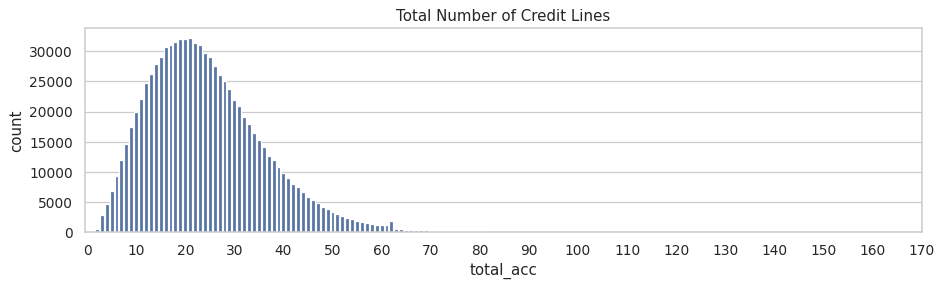

In [ ]:
# total_acc
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(data['total_acc'], order=sorted(data['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')


In [ ]:
train1.groupby('loan_status')['total_acc'].describe()


,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,406598.0,25.284692,11.852684,1.0,17.0,24.0,32.0,162.0
1,125814.0,25.211336,11.812416,1.0,17.0,24.0,32.0,104.0


Creating dummy variables

In [ ]:
data.shape

(887379, 17)

If any categorical variables have missing values,creating NaN dummy variables for those.

In [ ]:
missing_feature = data.isnull().mean().sort_values(ascending=False)

In [ ]:
 # Print variables that are missing data
print(missing_feature[missing_feature > 0])


revol_util        0.000566
total_acc         0.000033
pub_rec           0.000033
open_acc          0.000033
log_annual_inc    0.000005
dtype: float64


There are no categorical variables with missing values, and therefore no need any NaN dummy variables.

In [ ]:
# filling the missing values with mean 
data['total_acc'] = data['total_acc'].fillna( data['total_acc'].dropna().mean() )
data['log_annual_inc'] = data['log_annual_inc'].fillna( data['log_annual_inc'].dropna().mean() )
data['pub_rec'] = data['pub_rec'].fillna( data['pub_rec'].dropna().mean() )
data['open_acc'] = data['open_acc'].fillna( data['open_acc'].dropna().mean() )
data['revol_util'] = data['revol_util'].fillna( data['revol_util'].dropna().mean())

In [ ]:
print(data.columns)

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'home_ownership',
       'verification_status', 'purpose', 'addr_state', 'dti', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'log_annual_inc', 'log_revol_bal'],
      dtype='object')


In [ ]:
data = pd.get_dummies(data, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

In [ ]:
data.shape

(887379, 114)

In [ ]:
data.head()

,loan_amnt,term,int_rate,dti,open_acc,pub_rec,revol_util,total_acc,log_annual_inc,log_revol_bal,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,...,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_JOINT
0,14350,36,19.19,33.88,14.0,1.0,73.1,28.0,4.457897,4.352491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4800,36,10.99,3.64,6.0,0.0,23.2,13.0,4.812920,3.882240,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,10000,36,7.26,18.42,5.0,0.0,31.2,19.0,4.653222,4.036549,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,15000,36,19.72,14.97,10.0,0.0,55.5,21.0,5.021193,4.137132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,16000,36,10.64,20.16,11.0,0.0,76.2,27.0,4.716012,4.554320,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
X_train=data.iloc[:532428,]
y_train=loan_status
test_X=data.iloc[532428:,]
seed=7

In [ ]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


SMOTE is python library which is used when the data is imbalanced

In [ ]:
smote=SMOTE()
X_train_tf,y_train_tf=smote.fit_resample(X_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn import preprocessing

In [ ]:
# scaler = preprocessing.RobustScaler()
# X_train_tf = scaler.fit_transform(X_train_tf)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_train_tf,y_train_tf,random_state=seed)

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
# scaler = MinMaxScaler()

# # fit and transfrom
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # everything has been scaled between 1 and 0
# print('Max: ',X_train.max())
# print('Min: ', X_train.min())  

In [ ]:
lr = LogisticRegression(C=5.0)
knn = KNeighborsClassifier(weights='distance', algorithm='auto', n_neighbors=15)
rfc = RandomForestClassifier(n_estimators=200,criterion='gini')
dtc = DecisionTreeClassifier()
xgb = XGBClassifier()
ada = AdaBoostClassifier()
gbc = GradientBoostingClassifier()

In [ ]:
accuracy = {}
roc_r = {}

def train_model(model):
    # Checking accuracy
    model = model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)*100
    accuracy[model] = acc
    print('accuracy_score',acc)
    print('precision_score',precision_score(y_test, pred)*100)
    print('recall_score',recall_score(y_test, pred)*100)
    print('f1_score',f1_score(y_test, pred)*100)
    roc_score = roc_auc_score(y_test, pred)*100
    roc_r[model] = roc_score
    print('roc_auc_score',roc_score)
    # confusion matrix
    print('confusion_matrix')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)*100

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

accuracy_score 72.9465177249497
precision_score 66.69948260994538
recall_score 91.46711602514831
f1_score 77.14409195555149
roc_auc_score 72.97789377168556
confusion_matrix
       0      1
0  55482  46341
1   8659  92819


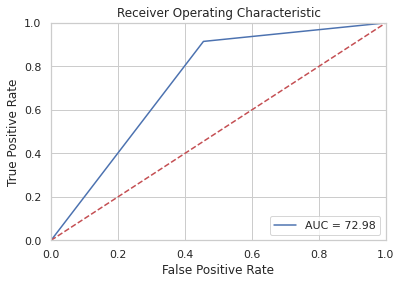

In [ ]:
train_model(knn)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy_score 59.657847231445004
precision_score 60.18142629948942
recall_score 56.681251108614674
f1_score 58.37892151389975
roc_auc_score 59.652804531552164
confusion_matrix
       0      1
0  63766  38057
1  43959  57519


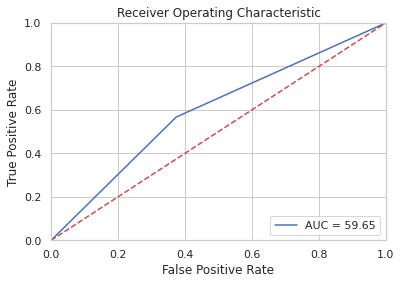

In [ ]:
train_model(lr)

accuracy_score 81.38867983925313
precision_score 81.04408737475732
recall_score 81.86109304479788
f1_score 81.45054147730893
roc_auc_score 81.38948016214636
confusion_matrix
       0      1
0  82393  19430
1  18407  83071


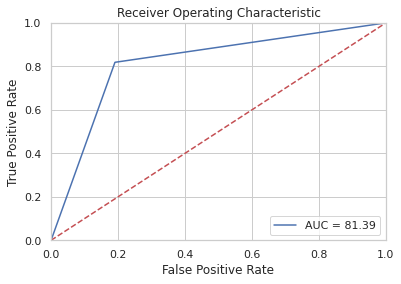

In [ ]:
train_model(dtc)

accuracy_score 86.55491119079592
precision_score 95.35577958304786
recall_score 76.80482469106605
f1_score 85.08083443404979
roc_auc_score 86.53839341071476
confusion_matrix
       0      1
0  98027   3796
1  23538  77940


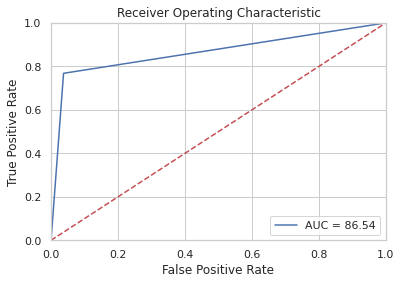

In [ ]:
train_model(rfc)

accuracy_score 84.74921421931029
precision_score 91.27068717131847
recall_score 76.79102859733145
f1_score 83.40709740603778
roc_auc_score 84.73573212764346
confusion_matrix
       0      1
0  94370   7453
1  23552  77926


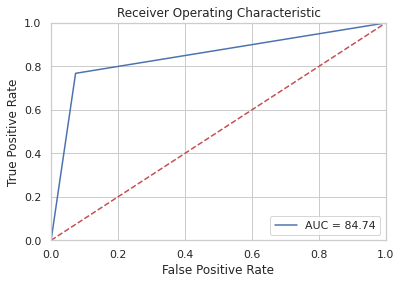

In [ ]:
train_model(xgb)

accuracy_score 82.78119635417436
precision_score 88.24978133775261
recall_score 75.56514712548534
f1_score 81.41636141636141
roc_auc_score 82.76897152783896
confusion_matrix
       0      1
0  91613  10210
1  24796  76682


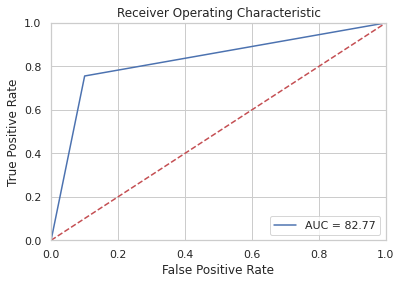

In [ ]:
train_model(ada)

accuracy_score 84.86579013384096
precision_score 91.29581610484266
recall_score 77.02359132028617
f1_score 83.55461484189597
roc_auc_score 84.85250453731229
confusion_matrix
       0      1
0  94371   7452
1  23316  78162


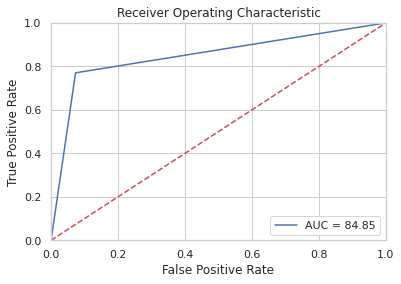

In [ ]:
train_model(gbc)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


accuracy_score 67.87128445015027
precision_score 63.41067216543785
recall_score 84.2438755198171
f1_score 72.35755154551917
roc_auc_score 67.89902152290905
confusion_matrix
       0      1
0  52494  49329
1  15989  85489


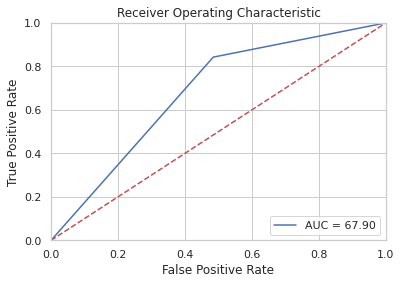

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
train_model(mlp)

In [ ]:
# Predicted values
y_head_lr = lr.predict(X_test)
y_head_knn = knn.predict(X_test)
y_head_xgb = xgb.predict(X_test)
y_head_dtc = dtc.predict(X_test)
y_head_rfc = rfc.predict(X_test)
y_head_ada = ada.predict(X_test)
y_head_gbc = gbc.predict(X_test)
y_head_mlp = mlp.predict(X_test)

In [ ]:
cm_lr = confusion_matrix(y_test,y_head_lr)
cm_knn = confusion_matrix(y_test,y_head_knn)
cm_xgb = confusion_matrix(y_test,y_head_xgb)
cm_dtc = confusion_matrix(y_test,y_head_dtc)
cm_rfc = confusion_matrix(y_test,y_head_rfc)


cm_ada = confusion_matrix(y_test,y_head_ada)
cm_gbc = confusion_matrix(y_test,y_head_gbc)
# cm_mlp = confusion_matrix(y_test,y_head_mlp)

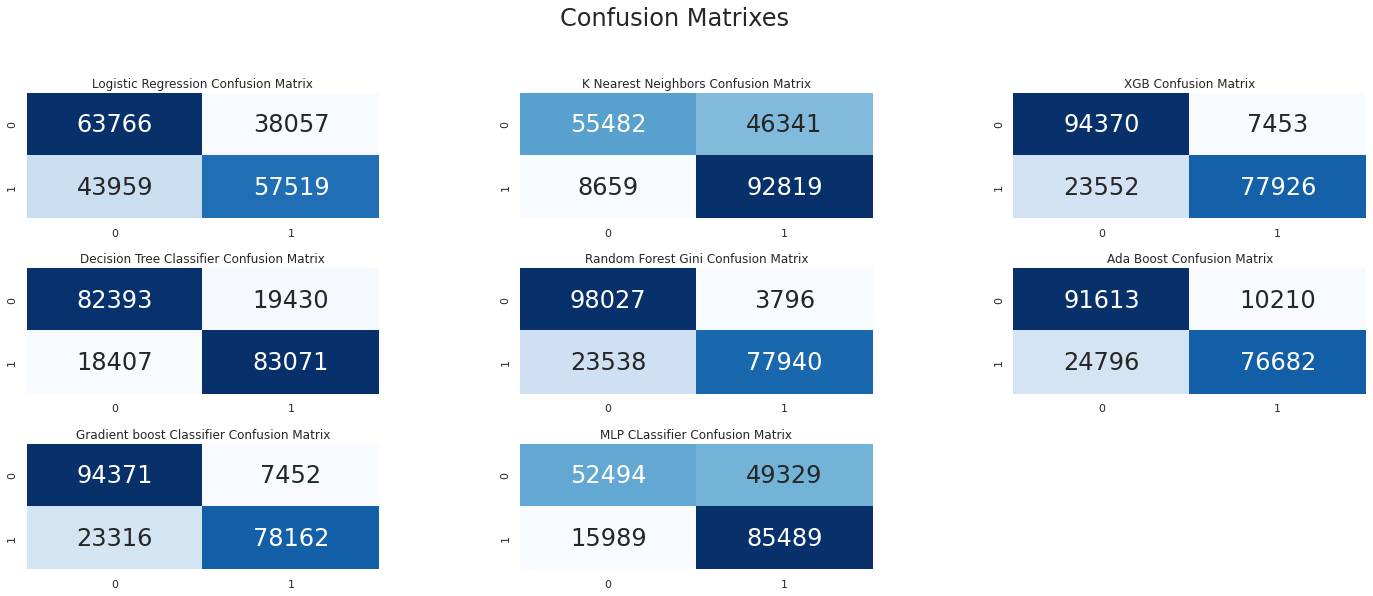

In [ ]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(4,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,3)
plt.title("XGB Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,4)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,5)
plt.title("Random Forest Gini Confusion Matrix")
sns.heatmap(cm_rfc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,6)
plt.title("Ada Boost Confusion Matrix")
sns.heatmap(cm_ada,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(4,3,7)
plt.title("Gradient boost Classifier Confusion Matrix")
sns.heatmap(cm_gbc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

# plt.subplot(4,3,8)
# plt.title("MLP CLassifier Confusion Matrix")
# sns.heatmap(cm_mlp,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
 

plt.show()

After analysing all the model's. We will chose Random Forest Classifier as its giving Good Accuracy and ROC-AUC score compare to all other models


In [ ]:
# sns.set_style("whitegrid")
# plt.figure(figsize=(16,5))
# plt.yticks(np.arange(0,100,10))
# plt.ylabel("ROC_score %")
# plt.xlabel("Algorithms")
# plt.xticks(rotation = 90)
# sns.barplot(x=list(roc_r.keys()), y=list(roc_r.values()))
# plt.show()

**HyperParameter Tuning**



In [ ]:
rfc = RandomForestClassifier(criterion = 'gini',
            n_estimators = 200, max_depth = 30,  
            min_samples_split = 2, 
            min_samples_leaf = 2)

In [ ]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Now train it with whole Traning dataset

In [ ]:
output=rfc.predict(test_X)

In [ ]:
submit=pd.DataFrame({'member_id':test['member_id'],'loan_status':output})

In [122]:
# submit['loan_status'].value_counts(normalize=True, dropna=False)

In [123]:
# submit['loan_status'].value_counts(dropna=False)

In [119]:
submission=submit.to_csv('/content/drive/MyDrive/Data Science/ML_Artivatic_dataset/submission.csv',index=False)